# Visualizations of the Summarized Predictions

In [2]:
import time
import os
import glob
import re
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
incerto_dir = '/content/drive/MyDrive/incerto-autore'
figures_dir = os.path.join(incerto_dir, 'figures')
output_dir = os.path.join(incerto_dir, 'output')
predictions_dir = os.path.join(incerto_dir, 'output','predictions')

In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

## Binary Classifiers

In [6]:
bin_pred = pd.read_csv(os.path.join(predictions_dir, 'predictions_binary.csv'))
print(len(bin_pred))
bin_pred = bin_pred.loc[(bin_pred['cv_f1-score'] > 0.7) & (bin_pred['f1-score'] > 0.7)].drop('cv_f1-score', axis=1)
print(len(bin_pred))
bin_pred['group_label'] = [x.split('_')[0] for x in bin_pred.label]

28780
28745


In [7]:
bin_whole_pred = bin_pred[bin_pred['poem_type'] == 'Whole'][['label', 'author',  'prediction', 'classifier', 'f1-score', 'poem_type', 'classifier_type']]
bin_whole_pred[:1]

,label,author,prediction,classifier,f1-score,poem_type,classifier_type
22020,UA11,Franco,0,kNN,0.853959,Whole,Binary


In [8]:
specs = ['group_label', 'classifier', 'author', 'vectorizer', 'ngram_type', 'ngram_range', 'max_df', 'min_df', 'max_f', 'num_f', 'scaler', 'poem_type', 'classifier_type']
bin_split_pred = bin_pred[bin_pred['poem_type'] == 'Split'].groupby(specs, as_index=False).mean().rename(columns={'group_label': 'label'})
bin_split_pred = bin_split_pred[['label', 'author', 'prediction', 'classifier', 'f1-score','poem_type', 'classifier_type']]
bin_split_pred[:1]

<ipython-input-8-a02632ae336c>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bin_split_pred = bin_pred[bin_pred['poem_type'] == 'Split'].groupby(specs, as_index=False).mean().rename(columns={'group_label': 'label'})


,label,author,prediction,classifier,f1-score,poem_type,classifier_type
0,UA1,Franco,0.538462,Logit,0.790749,Split,Binary


In [9]:
new_bin_pred = pd.concat([bin_split_pred, bin_whole_pred], ignore_index=True)
new_bin_pred[:1]

,label,author,prediction,classifier,f1-score,poem_type,classifier_type
0,UA1,Franco,0.538462,Logit,0.790749,Split,Binary


In [10]:
bin_bert_pred = pd.read_csv(os.path.join(predictions_dir, 'predictions_binary_bertoldo.csv'))
bin_bert_pred['classifier_type'] = 'Binary'
bin_bert_pred['poem_type'] = 'Split'
f1_scores = {}
for author in bin_bert_pred.author.unique():
  finetuned_path = os.path.join(incerto_dir, 'output','finetuned-models', 'binary-class', 'bertoldo', author, 'classification_report.csv')
  df = pd.read_csv(finetuned_path)
  f1_scores[author] = {}
  f1_scores[author]['f1-score'] = df.loc[:, 'f1-score'][3]
  #f1_scores[author]['f1-score_1'] = df.loc[:, 'f1-score'][1]
f1_scores

{'Franco': {'f1-score': 0.9375639258238092},
 'Petrarca': {'f1-score': 0.8260481712756468},
 'CelioMagno': {'f1-score': 0.8873646209386281}}

In [11]:
bin_bert_pred['f1-score'] = [f1_scores[au]['f1-score'] for au in bin_bert_pred.author.tolist()]
#bin_bert_pred['f1-score_1'] = [f1_scores[au]['f1-score_1'] for au in bin_bert_pred.author.tolist()]
bin_bert_pred['group_label'] = [x.split('_')[0] for x in bin_bert_pred.label]
new_bin_bert_pred = bin_bert_pred.groupby(['group_label', 'author', 'classifier', 'classifier_type', 'poem_type'], as_index=False).mean().rename(columns={'group_label': 'label'})
new_bin_bert_pred[:1]

<ipython-input-11-745f711f0132>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_bin_bert_pred = bin_bert_pred.groupby(['group_label', 'author', 'classifier', 'classifier_type', 'poem_type'], as_index=False).mean().rename(columns={'group_label': 'label'})


,label,author,classifier,classifier_type,poem_type,prediction,f1-score
0,UA1,CelioMagno,BERToldo,Binary,Split,0.011328,0.887365


In [12]:
bin_pred_df = pd.concat([new_bin_pred, new_bin_bert_pred])
print(len(bin_pred_df))
bin_pred_df[:1]

9156


,label,author,prediction,classifier,f1-score,poem_type,classifier_type
0,UA1,Franco,0.538462,Logit,0.790749,Split,Binary


## Multiclass Classifiers

In [13]:
multi_pred = pd.read_csv(os.path.join(predictions_dir, 'predictions_multiclass.csv'))
print(len(multi_pred))
multi_pred[:1]

360


,label,prediction,classifier,vectorizer,ngram_type,ngram_range,max_df,min_df,max_f,num_f,...,cv_f1-score,f1-score,AntonGiacomoCorso_f1,CelioMagno_f1,DomenicoVenier_f1,Franco_f1,GiorgioGradenigo_f1,MarcoVenier_f1,Petrarca_f1,PietroBembo_f1
0,UA11_1,Franco,Logit,Count,Word,Unigrams,0.8,0.0,1000,1000,...,0.438551,0.370928,0.4,0.521739,0.166667,0.848921,0.0,0.0,0.769231,0.26087


In [14]:
multi_whole_pred = multi_pred[multi_pred['poem_type'] == 'Whole'].copy()

f1score_au = []
for index, row in multi_whole_pred.iterrows():
  au = row['prediction']
  key = f'{au}_f1'
  f1score_au.append(row[key])
multi_whole_pred['au_f1-score'] = f1score_au
multi_whole_pred['author'] = multi_whole_pred['prediction']
multi_whole_pred['prediction'] = 1

multi_whole_pred = multi_whole_pred[['label', 'author', 'prediction', 'classifier', 'f1-score', 'au_f1-score', 'poem_type', 'classifier_type']]

In [15]:
multi_split_pred = multi_pred[multi_pred['poem_type'] == 'Split'].copy()
multi_split_pred['group_label'] = [x.split('_')[0] for x in multi_split_pred.label]
print(len(multi_split_pred.label.unique()))

new_structure = []
for i in range(0, len(multi_split_pred), 60): # for each 60 predictions, 60 split poems, for each model
  one_model = multi_split_pred[i:i+60]

  for group_label in one_model.group_label.unique(): # group by whole poem
    df = one_model[one_model['group_label'] == group_label].copy()
    classifier = df.iloc[1,:]['classifier']
    f1score = df.iloc[1,:]['f1-score']

    N = len(df)
    for author in df.prediction.unique(): # calculate probability for each predicted author
      p = len(df[df['prediction'] == author])/N
      key = f'{author}_f1'
      au_f1 = df.iloc[1,:][key]
      new_structure.append([group_label, author, p, classifier, f1score, au_f1, 'Split', 'Multiclass'])

new_multi_split_pred = pd.DataFrame(new_structure, columns=['label', 'author', 'prediction', 'classifier', 'f1-score', 'au_f1-score', 'poem_type', 'classifier_type'])
print(len(new_multi_split_pred))
new_multi_split_pred[:1]

60
90


,label,author,prediction,classifier,f1-score,au_f1-score,poem_type,classifier_type
0,UA11,Franco,0.888889,Logit,0.370928,0.848921,Split,Multiclass


In [16]:
new_multi_pred = pd.concat([new_multi_split_pred, multi_whole_pred], ignore_index=True)
new_multi_pred[:1]

,label,author,prediction,classifier,f1-score,au_f1-score,poem_type,classifier_type
0,UA11,Franco,0.888889,Logit,0.370928,0.848921,Split,Multiclass


In [17]:
label2id = {'AntonGiacomoCorso': 0, 'CelioMagno': 1, 'DomenicoVenier': 2, 'Franco': 3, 'GiorgioGradenigo': 4, 'MarcoVenier': 5, 'Petrarca': 6, 'PietroBembo': 7, 'macro avg': 9}

In [18]:
multi_bert_pred = pd.read_csv(os.path.join(predictions_dir, 'predictions_multi_bertoldo.csv'))
multi_bert_pred['classifier_type'] = 'Multiclass'
multi_bert_pred['poem_type'] = 'Split'

f1_scores = {}
for key in label2id:
  finetuned_path = os.path.join(incerto_dir, 'output','finetuned-models', 'multi-class', 'bertoldo', 'classification_report.csv')
  df = pd.read_csv(finetuned_path)
  idx = label2id[key]
  f1_scores[key] = df.loc[:, 'f1-score'][idx]
f1_scores

{'AntonGiacomoCorso': 0.4,
 'CelioMagno': 0.631578947368421,
 'DomenicoVenier': 0.1666666666666666,
 'Franco': 0.8468468468468469,
 'GiorgioGradenigo': 0.0,
 'MarcoVenier': 0.0,
 'Petrarca': 0.7142857142857143,
 'PietroBembo': 0.5454545454545454,
 'macro avg': 0.4131040900777743}

In [19]:
multi_bert_pred['f1-score'] = f1_scores['macro avg']
multi_bert_pred['au_f1-score'] = [f1_scores[au] for au in multi_bert_pred.author.tolist()]
multi_bert_pred['group_label'] = [x.split('_')[0] for x in multi_bert_pred.label]
new_multi_bert_pred = multi_bert_pred.groupby(['group_label', 'author', 'classifier', 'classifier_type', 'poem_type'], as_index=False).mean().rename(columns={'group_label': 'label'})
new_multi_bert_pred[:1]

<ipython-input-19-ff9641330b62>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_multi_bert_pred = multi_bert_pred.groupby(['group_label', 'author', 'classifier', 'classifier_type', 'poem_type'], as_index=False).mean().rename(columns={'group_label': 'label'})


,label,author,classifier,classifier_type,poem_type,prediction,f1-score,au_f1-score
0,UA1,AntonGiacomoCorso,BERToldo,Multiclass,Split,0.044802,0.413104,0.4


In [20]:
multi_pred_df = pd.concat([new_multi_pred, new_multi_bert_pred], ignore_index=True)
cond = (multi_pred_df['f1-score'] > 0.7) | (multi_pred_df['au_f1-score'] > 0.7)
multi_pred_df = multi_pred_df.loc[cond].reset_index(drop=True).copy()
multi_pred_df.reset_index()
print(len(multi_pred_df))
multi_pred_df[:10]

84


,label,author,prediction,classifier,f1-score,au_f1-score,poem_type,classifier_type
0,UA11,Franco,0.888889,Logit,0.370928,0.848921,Split,Multiclass
1,UA14,Franco,0.909091,Logit,0.370928,0.848921,Split,Multiclass
2,UA14,Petrarca,0.090909,Logit,0.370928,0.769231,Split,Multiclass
3,UA4,Franco,1.000000,Logit,0.370928,0.848921,Split,Multiclass
4,UA6,Franco,1.000000,Logit,0.370928,0.848921,Split,Multiclass
5,UA7,Franco,0.769231,Logit,0.370928,0.848921,Split,Multiclass
6,UA7,Petrarca,0.153846,Logit,0.370928,0.769231,Split,Multiclass
7,UA9,Franco,0.666667,Logit,0.370928,0.848921,Split,Multiclass
8,UA9,Petrarca,0.166667,Logit,0.370928,0.769231,Split,Multiclass
9,UA1,Franco,0.769231,Logit,0.370928,0.848921,Split,Multiclass


## All

In [24]:
bin = bin_pred_df #.drop(columns=['f1-score_1'])
multi = multi_pred_df.drop(columns=['f1-score']).rename(columns={'au_f1-score':'f1-score'})
all_pred = pd.concat([bin, multi], ignore_index=True)
all_pred[:3]

,label,author,prediction,classifier,f1-score,poem_type,classifier_type
0,UA1,Franco,0.538462,Logit,0.790749,Split,Binary
1,UA1,Franco,0.538462,Logit,0.790749,Split,Binary
2,UA1,Franco,0.538462,Logit,0.810417,Split,Binary


In [25]:
for author in all_pred.author.unique():
  n = len(all_pred.loc[all_pred['author'] == author][['f1-score']])/7
  print(author, n)

Franco 772.0
Petrarca 539.0
PietroBembo 8.0
CelioMagno 1.0


## Probabilities

In [ ]:
probabilities = []
for label in all_pred.label.unique():
  df = all_pred[(all_pred['label'] == label) & (all_pred['author'] == 'Franco')]
  prob = df.prediction.mean()
  df1 = all_pred[(all_pred['label'] == label) & (all_pred['author'] == 'Franco') & (all_pred['poem_type'] == 'Split')]
  prob1 = df1.prediction.mean()
  df2 = all_pred[(all_pred['label'] == label) & (all_pred['author'] == 'Franco') & (all_pred['poem_type'] == 'Whole')]
  prob2 = df2.prediction.mean()
  probabilities.append({'Poem by Franco?' : label, 'Probability All %': round(prob*100),
                        'Probability Split %': round(prob1*100), 'Probability Whole %': round(prob2*100)})

probabilities_df = pd.DataFrame(probabilities).sort_values('Probability All %', ascending=False)
probabilities_df

,Poem by Franco?,Probability All %,Probability Split %,Probability Whole %
2,UA14,81,70,89
5,UA7,75,50,97
0,UA1,60,40,78
4,UA6,38,82,0
6,UA9,35,54,19
1,UA11,27,17,35
3,UA4,20,30,11


In [ ]:
votes = []
for label in all_pred.label.unique():
  df = all_pred[(all_pred['label'] == label) & (all_pred['author'] == 'Franco')]
  yes = 0
  no = 0
  N = len(df)
  for prediction in df.prediction:
    if prediction > 0.80:
      yes += 1
    else:
      no += 1
  votes.append({'Poem by Franco?' : label, 'Yes %': round(yes/N*100), 'No %': round(no/N*100)})

votes_df = pd.DataFrame(votes).sort_values('Yes %', ascending=False)
votes_df

,Poem by Franco?,Yes %,No %
2,UA14,66,34
5,UA7,55,45
0,UA1,42,58
4,UA6,31,69
1,UA11,19,81
6,UA9,15,85
3,UA4,7,93


## Scatterplots simple

In [26]:
scatter_dir_easy = os.path.join(figures_dir, 'predictions')
if not os.path.exists(scatter_dir_easy):
  os.makedirs(scatter_dir_easy)

In [33]:
def make_scatterplots_easy(_pred_df, _scatter_dir_easy):

  for label in _pred_df.label.unique():

    for author in ['Franco']:#_pred_df.author.unique():

      _figure = plt.figure(figsize = (4.3,4), tight_layout=0.5)
      plt.suptitle(f'{label}, {author} classifier', size=12)

      cond = (_pred_df['label'] == label) & (_pred_df['author'] == author)
      df = _pred_df.loc[cond].copy()

      ax = sns.scatterplot(data=df, x='f1-score', y='prediction', s=40)

      ax.set_xlim(0.685,1.015)
      ax.set_ylim(-0.05,1.05)
      ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
      ax.tick_params(axis='x', labelrotation=30)
      ax.set_ylabel(f'Average predicted probability')
      ax.set_xlabel(f'F-1 score')

      _figure.savefig(os.path.join(_scatter_dir_easy, f'{label}_{author}.png'), dpi = 300, bbox_inches = "tight")

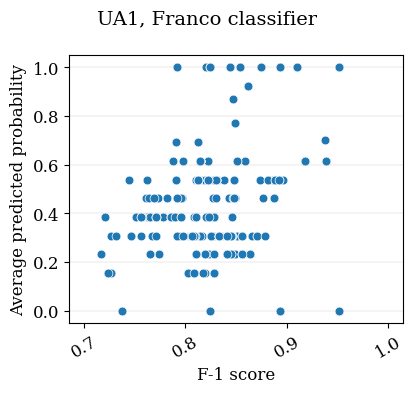

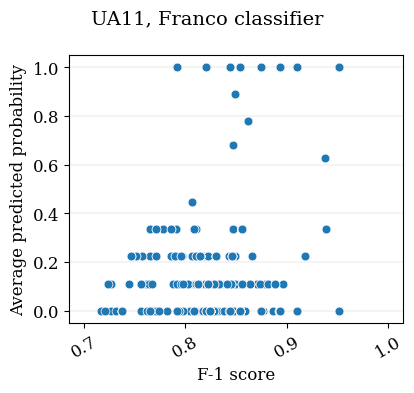

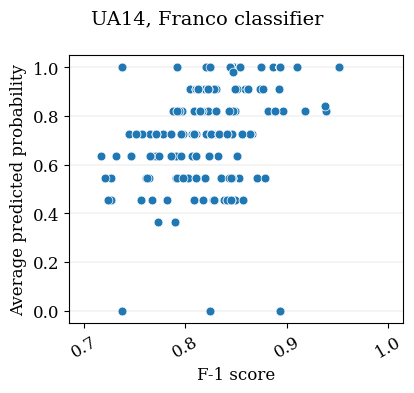

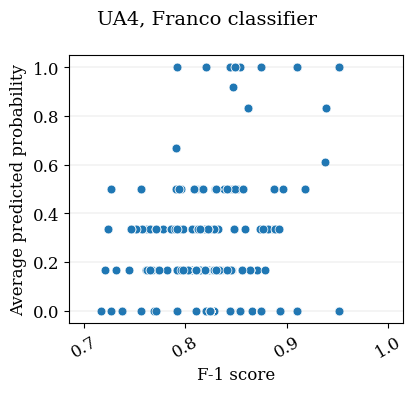

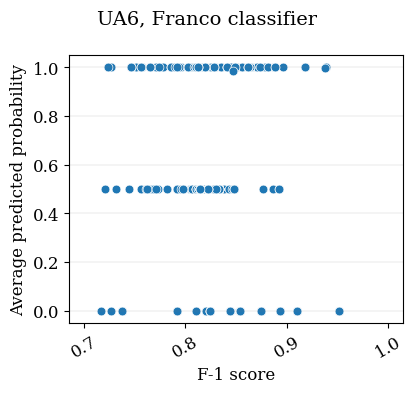

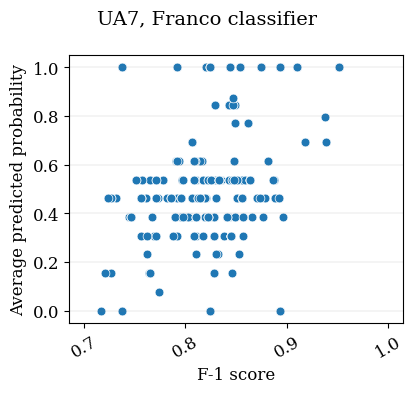

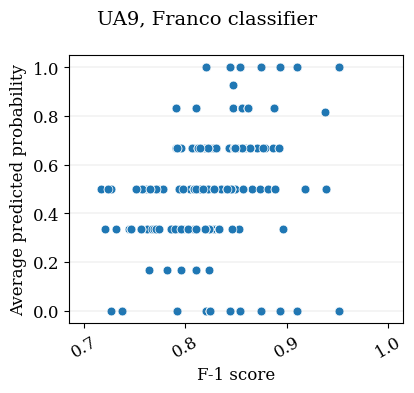

In [34]:
make_scatterplots_easy(all_pred, scatter_dir_easy)

## Scatterplots extended

In [ ]:
clrs = ['tomato', 'orange', 'gold', 'olivedrab', 'mediumseagreen', 'darkturquoise', 'cornflowerblue', 'mediumpurple', 'plum']

In [ ]:
pltt = sns.color_palette('colorblind')
hue_map = {'classifier_type': ({'Binary': 'orange', 'Multiclass': 'darkorchid'}, 'Classification\n       task'),
           'classifier' :
           ({'Logit': pltt[0], 'RandomForest': pltt[1],'SVM': pltt[9],  'kNN': pltt[3], 'BERToldo': pltt[4]}, 'Classifier'),
           'poem_type': ({'Split': 'cornflowerblue', 'Whole': 'tomato'}, 'Poem size')}

In [ ]:
scatter_dir = os.path.join(figures_dir, 'predictions', 'scatterplots')
if not os.path.exists(scatter_dir):
  os.makedirs(scatter_dir)

In [ ]:
def make_scatterplots(_pred_df, _hue_map, _scatter_dir):

  for label in _pred_df.label.unique():

    for author in _pred_df.author.unique():

      _figure = plt.figure(figsize = (16,4), tight_layout=0.5)
      plt.suptitle(f'{label}, {author} classifier', size=15)
      pos = 1

      for _hue, _tuple in _hue_map.items():

        _figure.add_subplot(1,3,pos)
        cond = (_pred_df['label'] == label) & (_pred_df['author'] == author)
        df = _pred_df.loc[cond].copy()

        ax = sns.scatterplot(data=df, x='f1-score', y='prediction', hue=_hue, palette=_tuple[0], s=40)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05,1.025),
                  fontsize='medium', fancybox=True, title=_tuple[1])

        ax.set_xlim(0.685,1.015)
        ax.set_ylim(-0.05,1.05)
        ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
        ax.tick_params(axis='x', labelrotation=30)
        ax.set_ylabel(f'Average predicted probability')
        ax.set_xlabel(f'F-1 score')
        pos += 1

      _figure.savefig(os.path.join(_scatter_dir, f'{label}_{author}.png'), dpi = 300, bbox_inches = "tight")


<ipython-input-24-e97c4112d9fd>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _figure = plt.figure(figsize = (16,4), tight_layout=0.5)


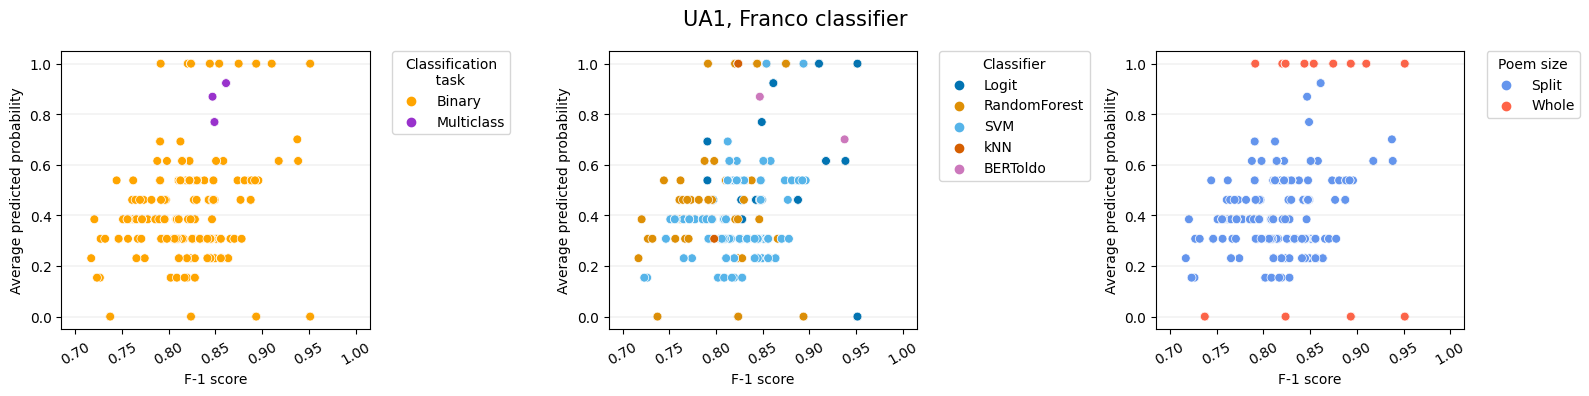

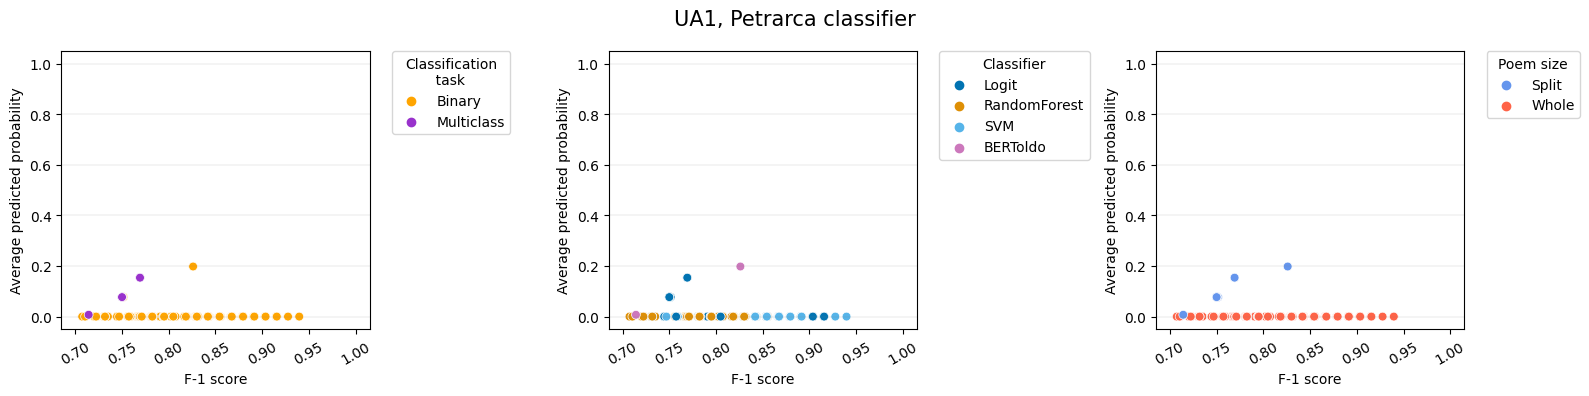

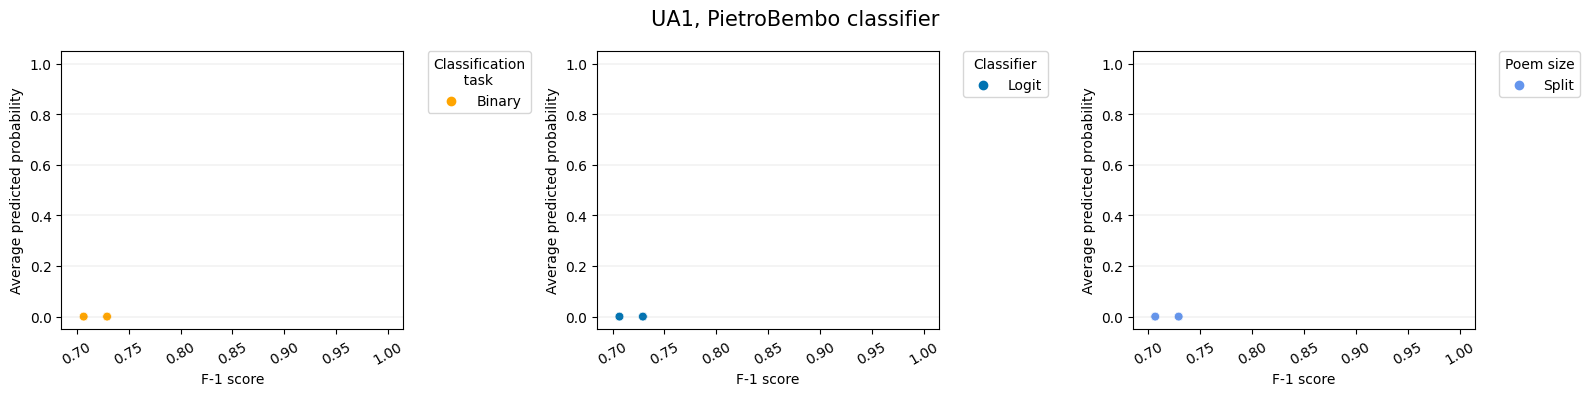

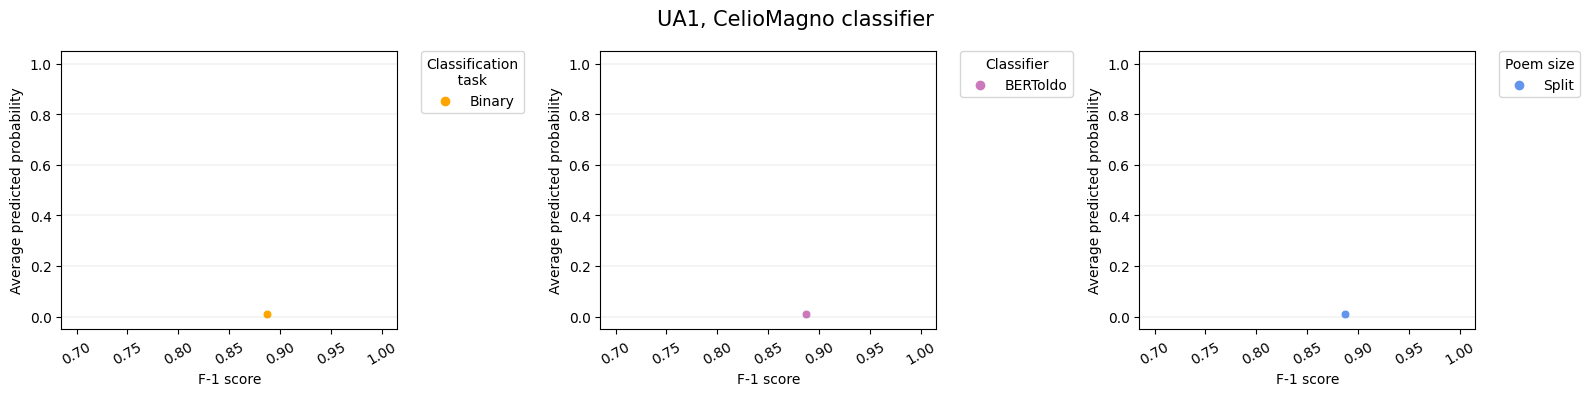

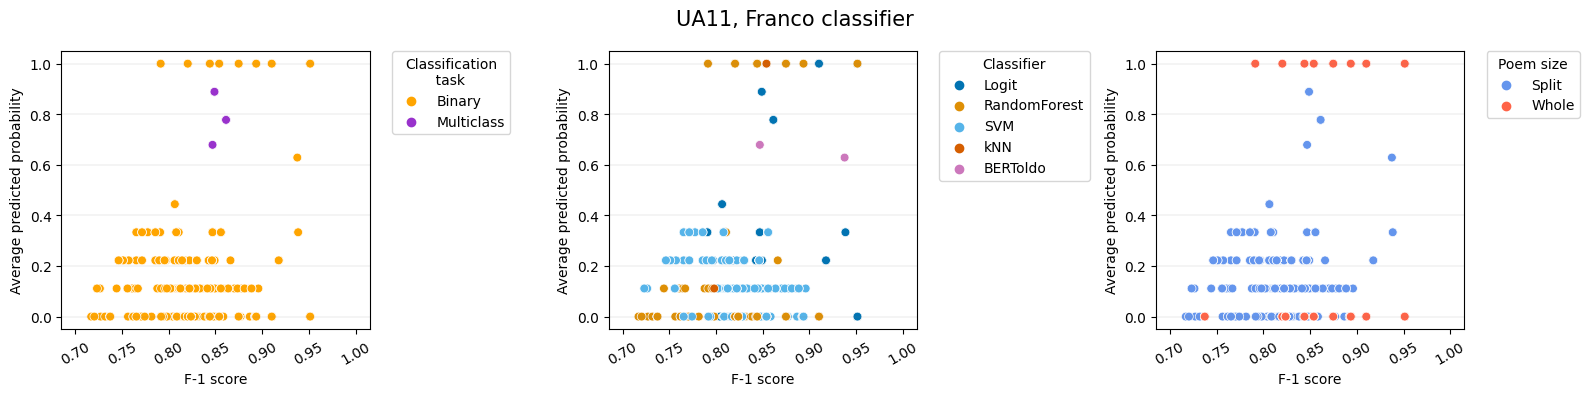

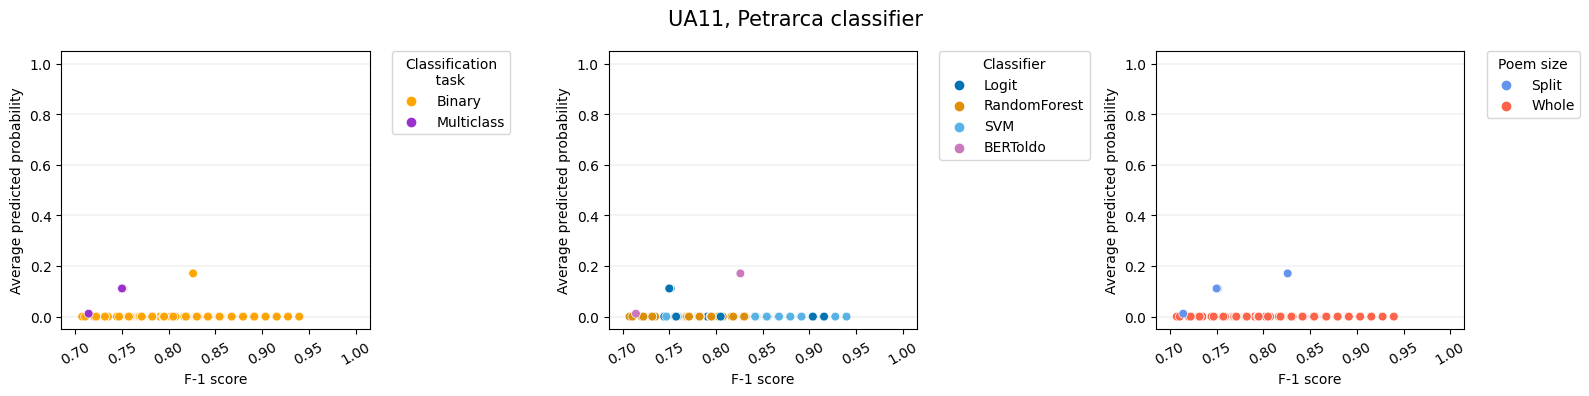

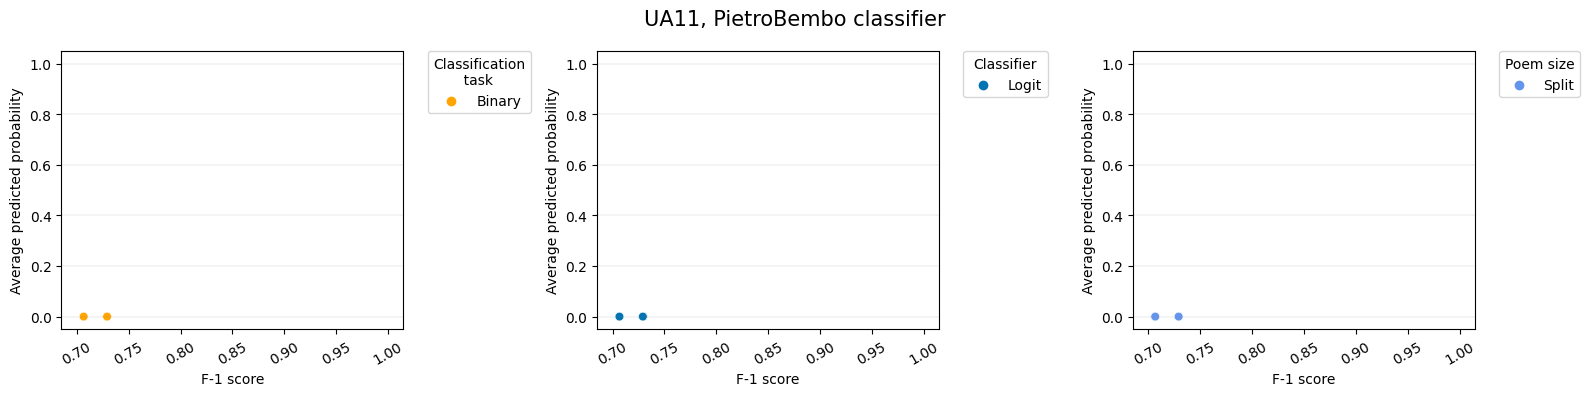

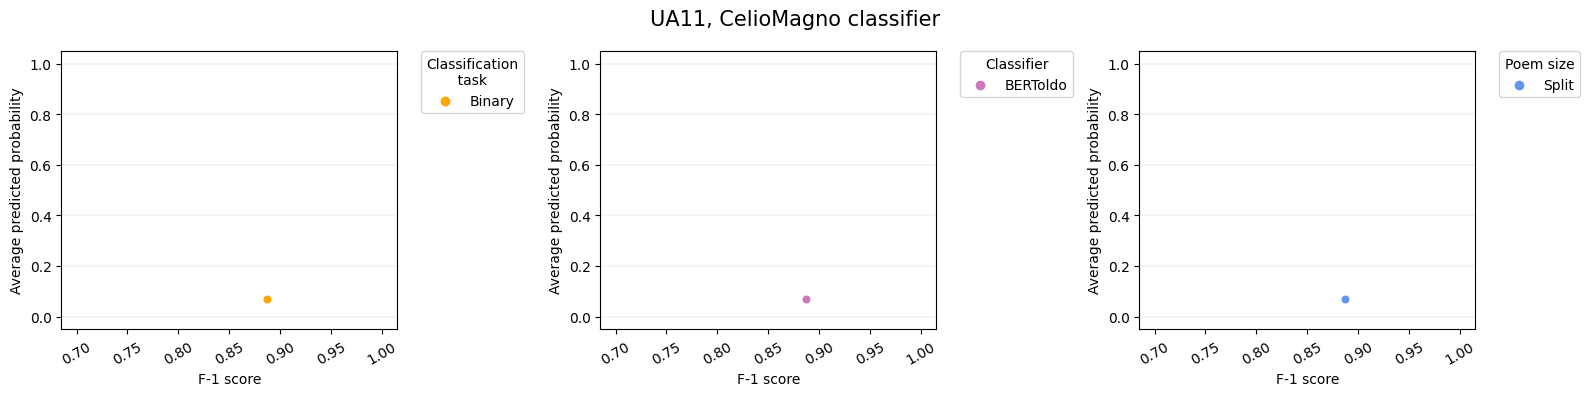

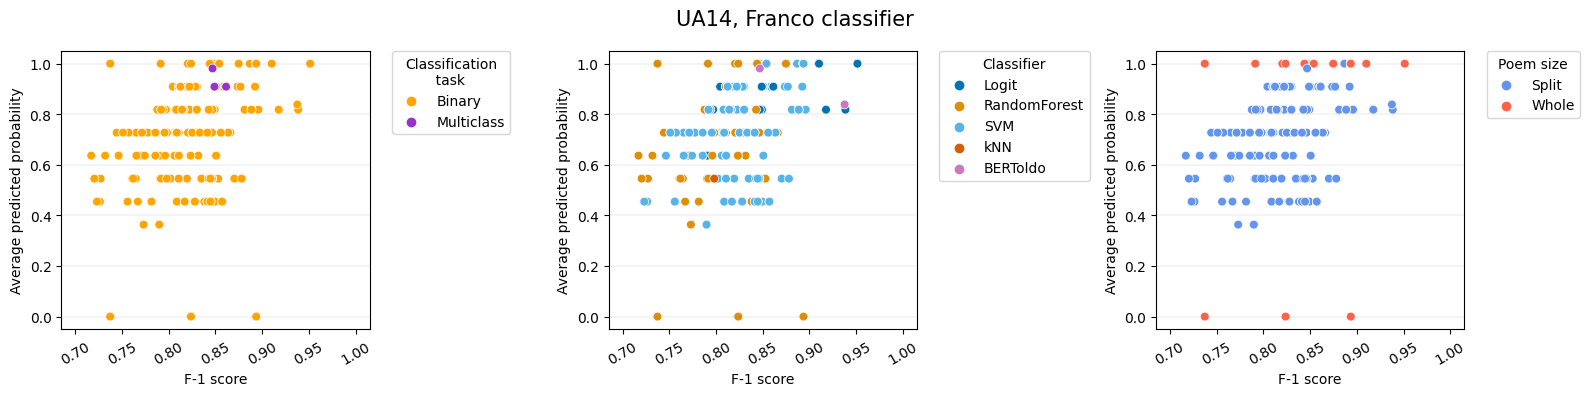

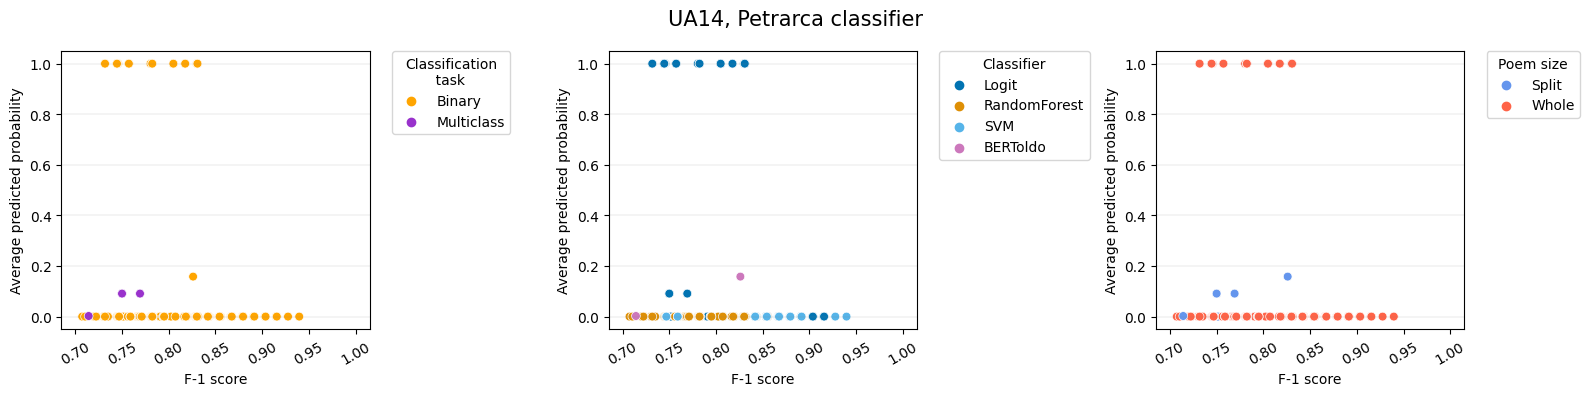

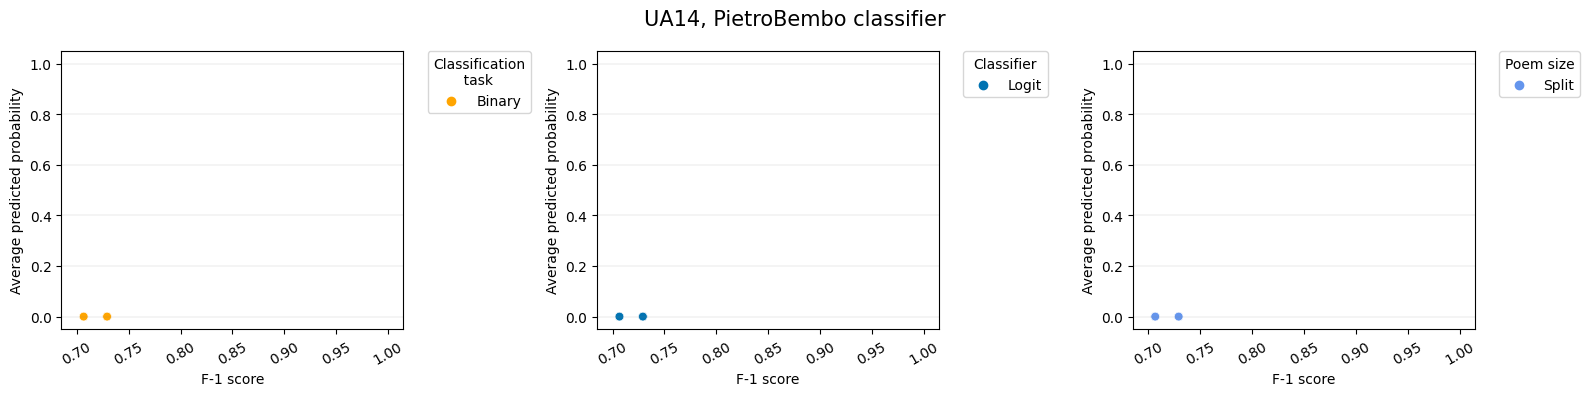

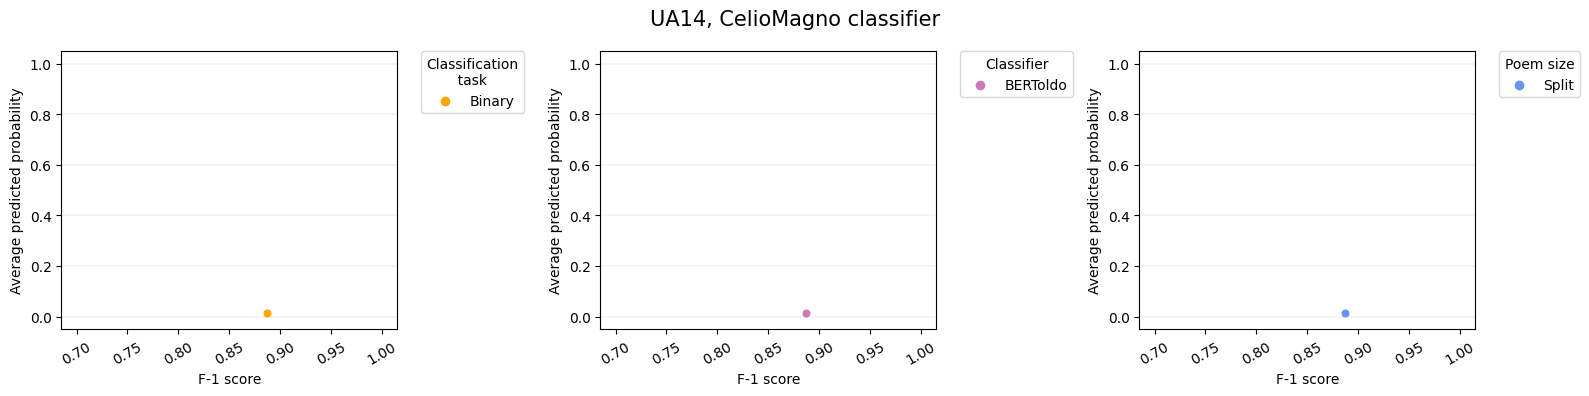

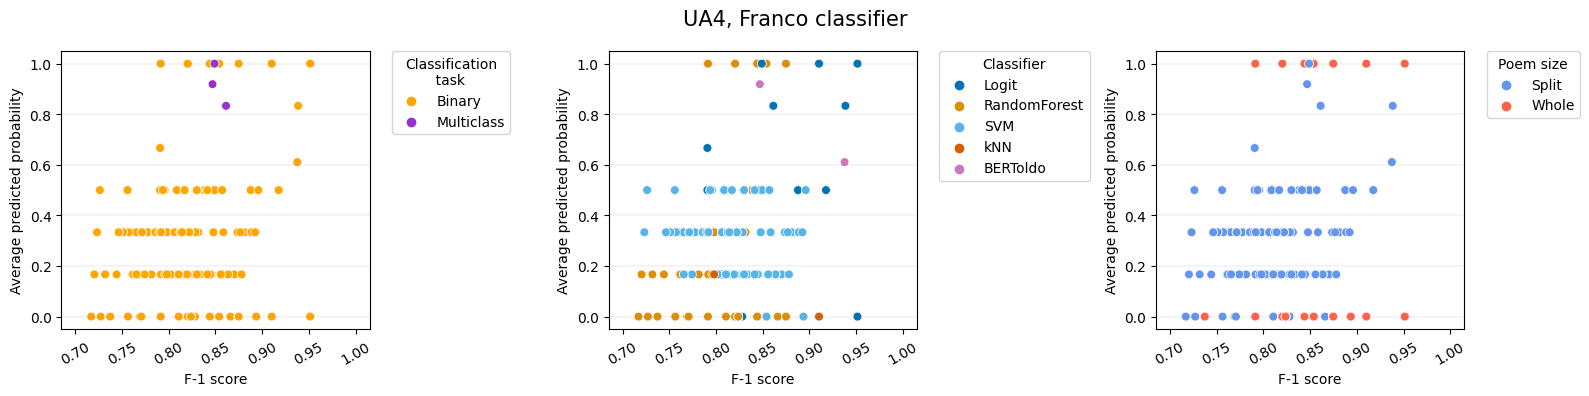

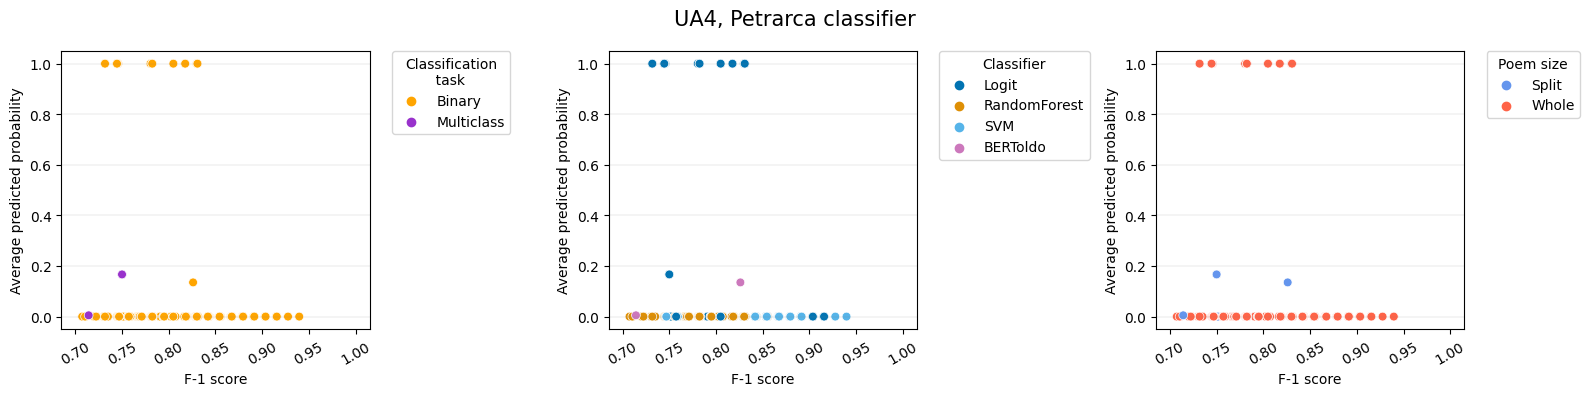

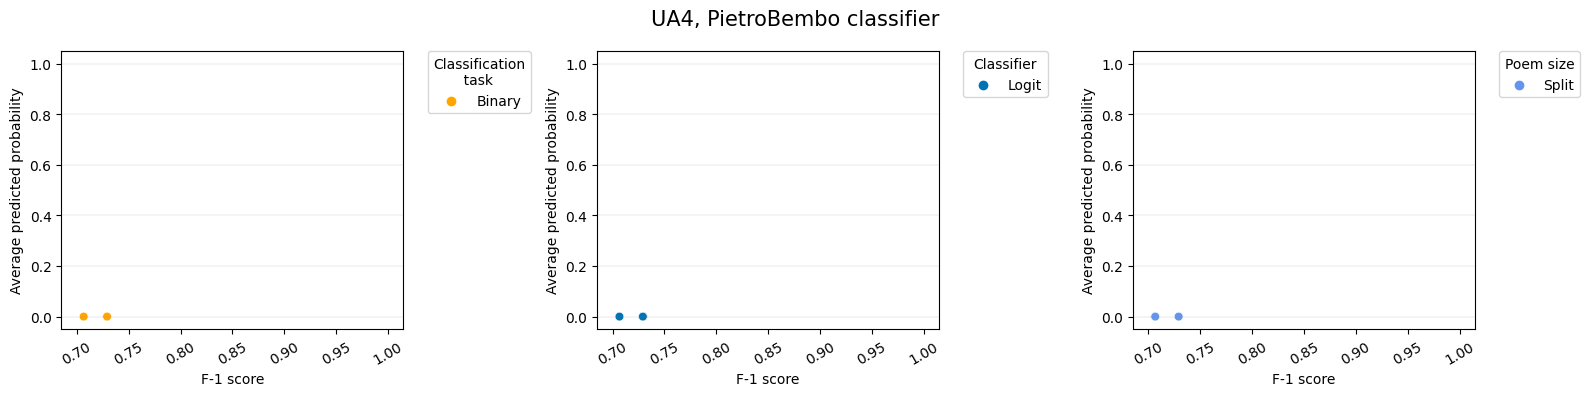

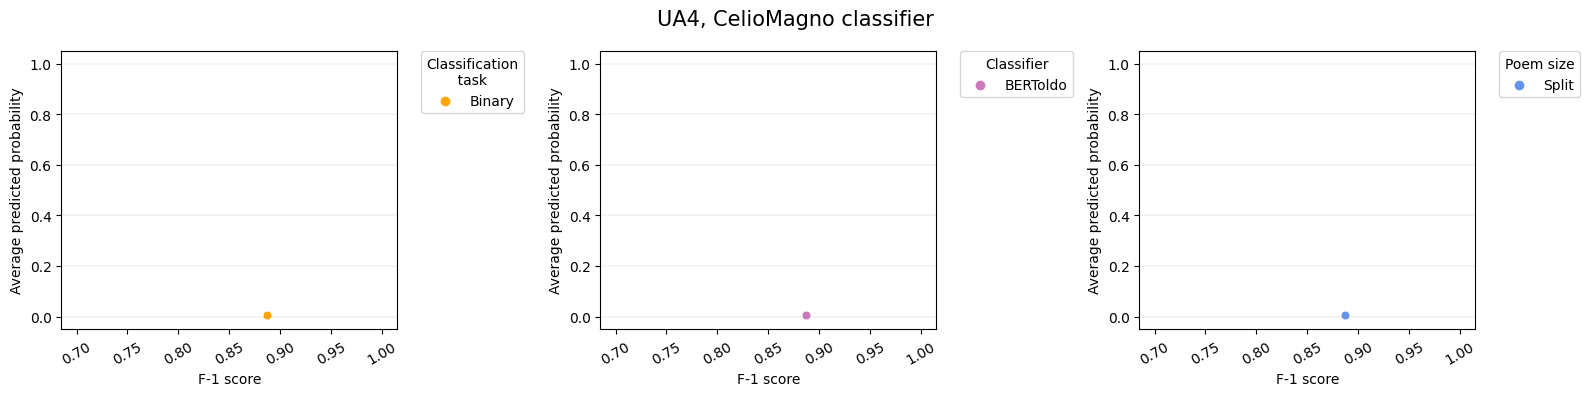

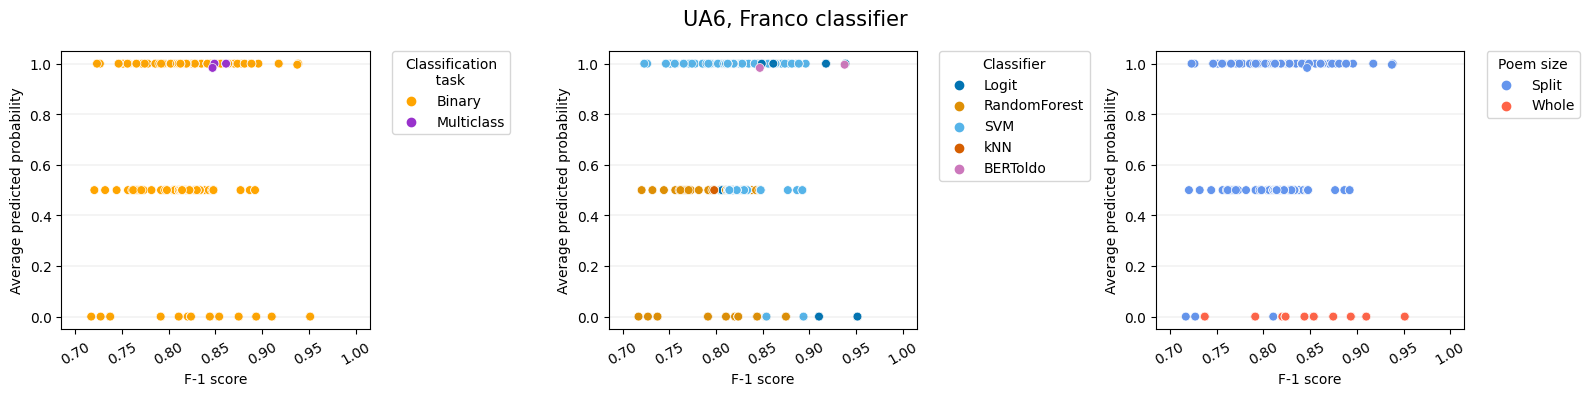

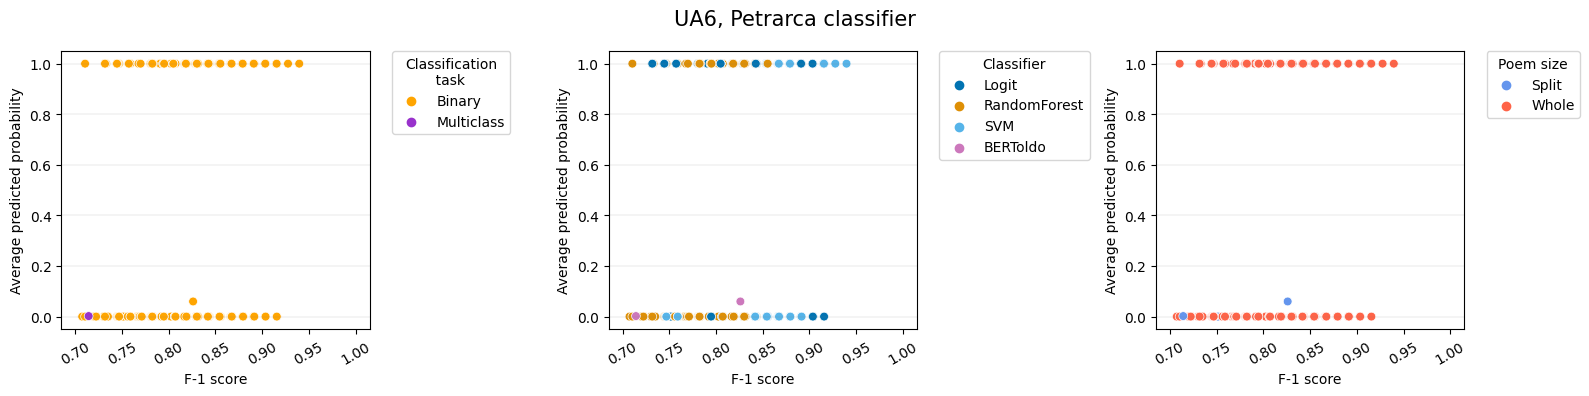

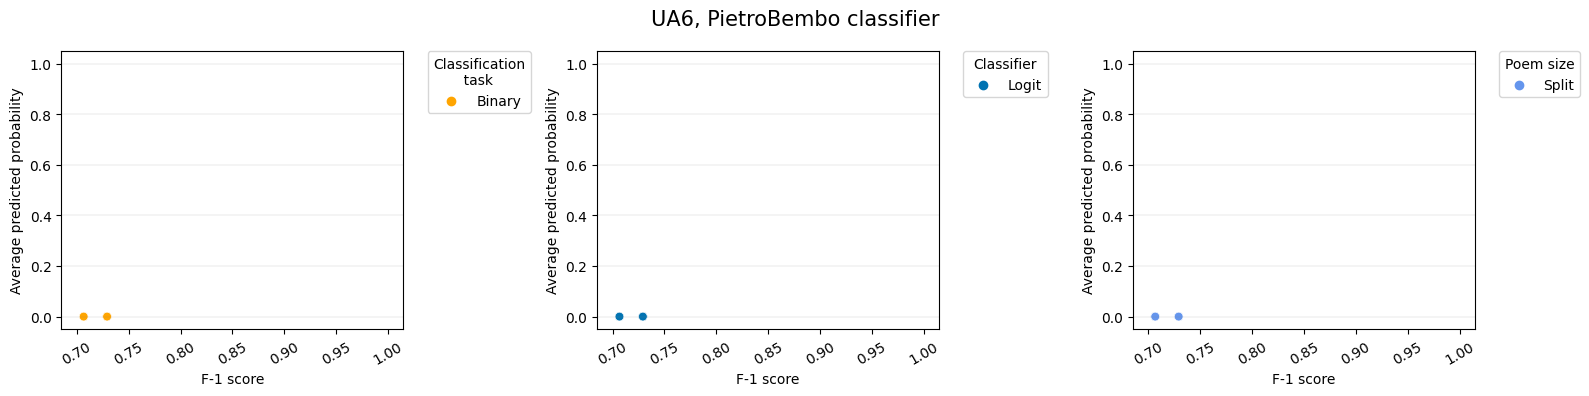

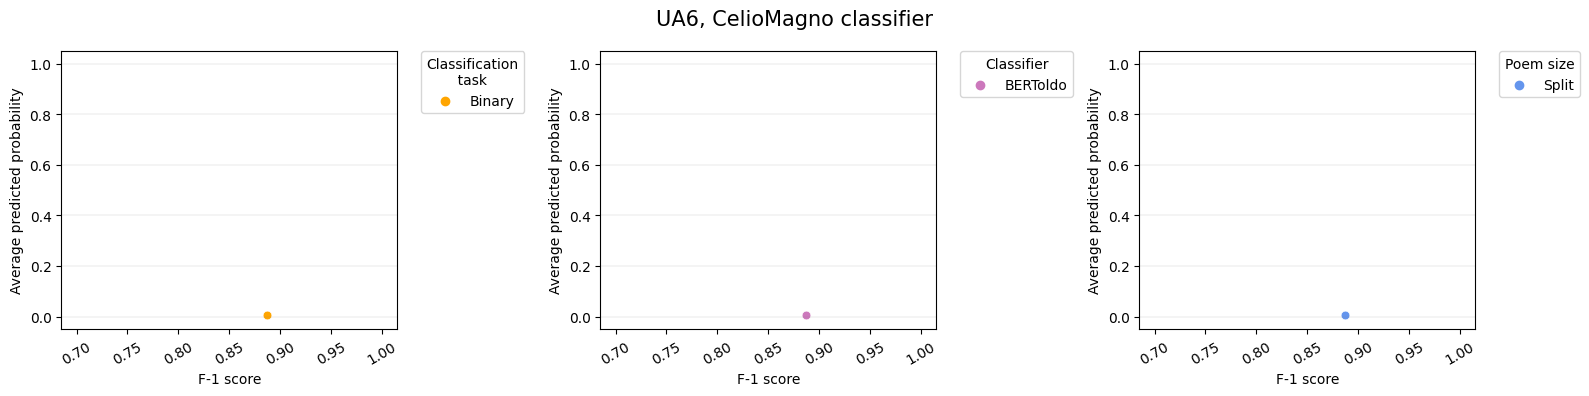

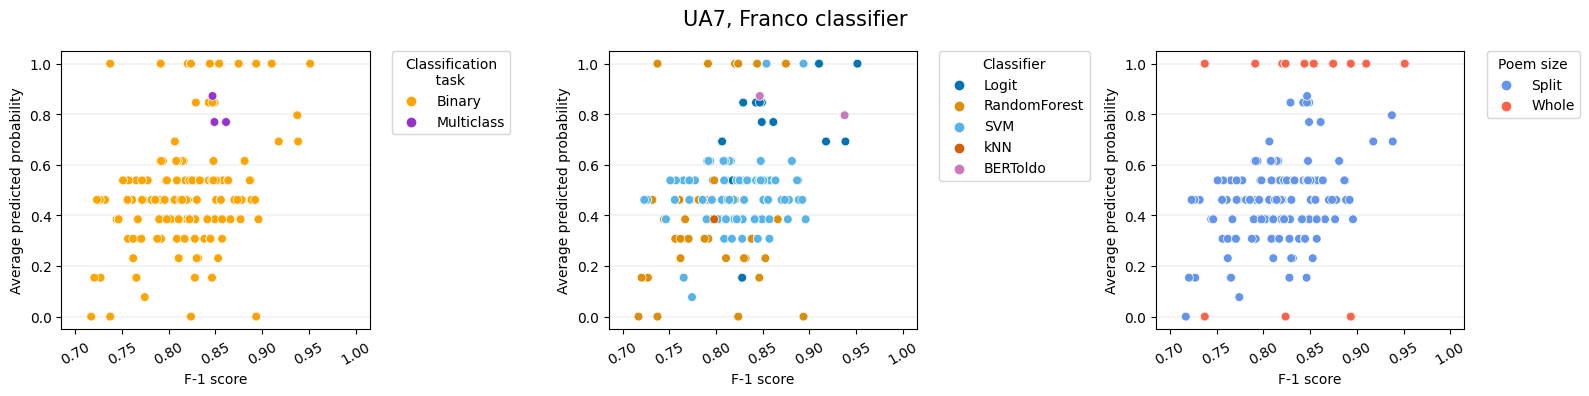

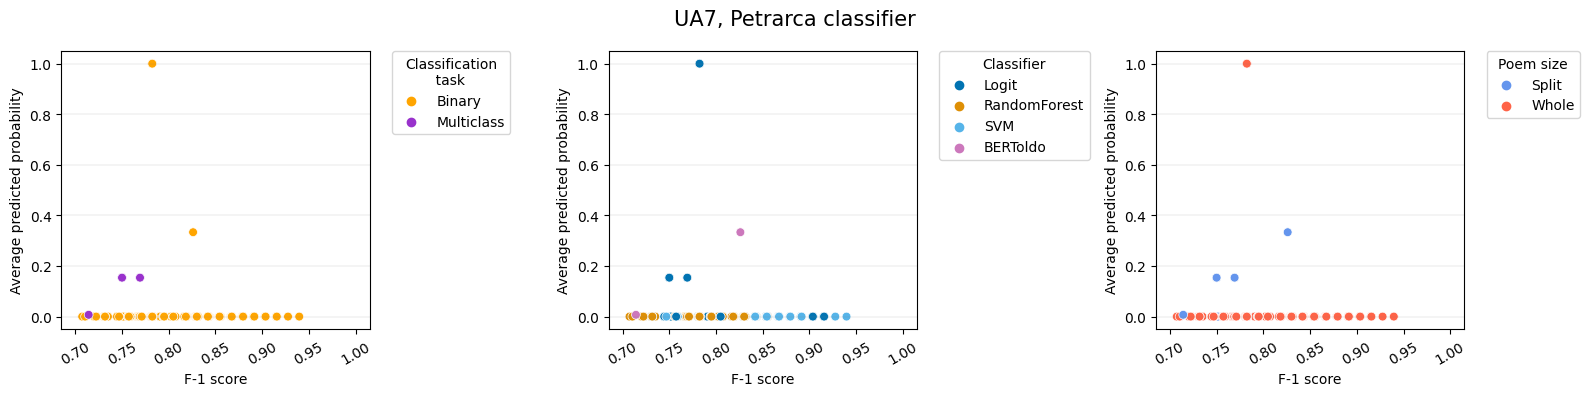

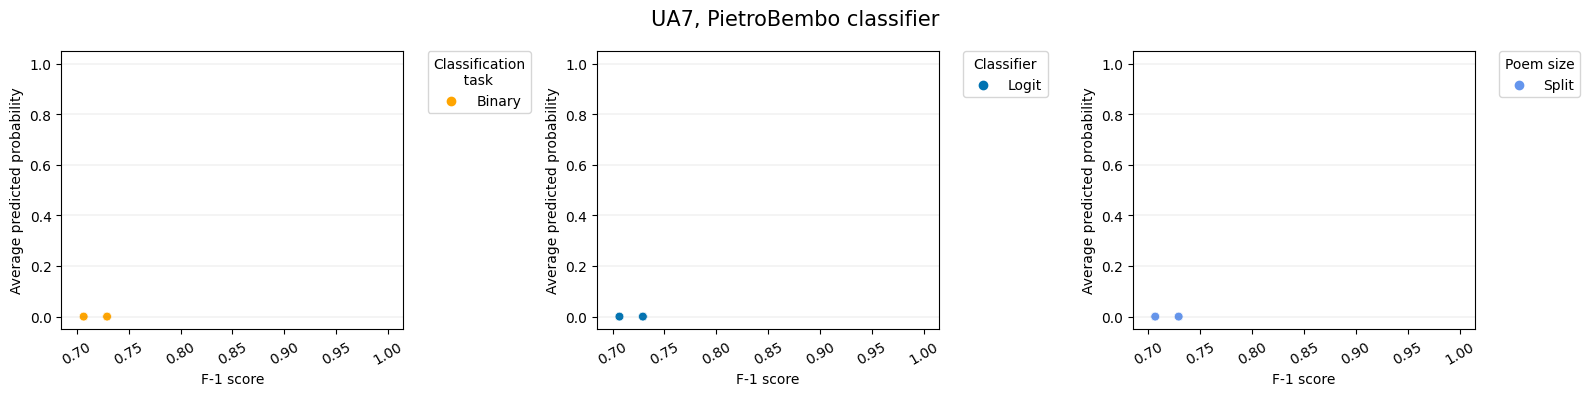

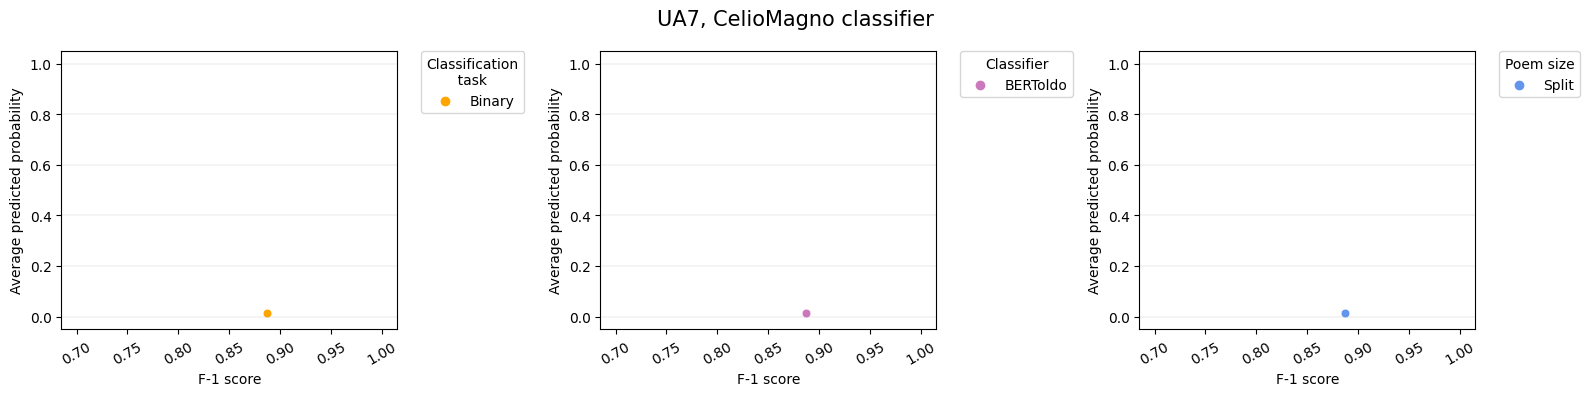

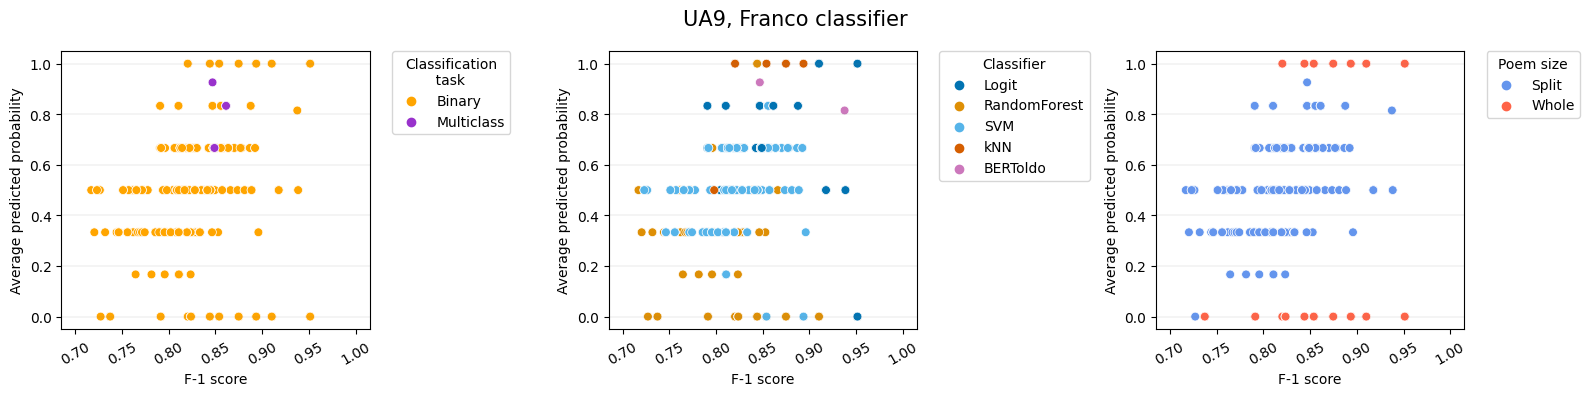

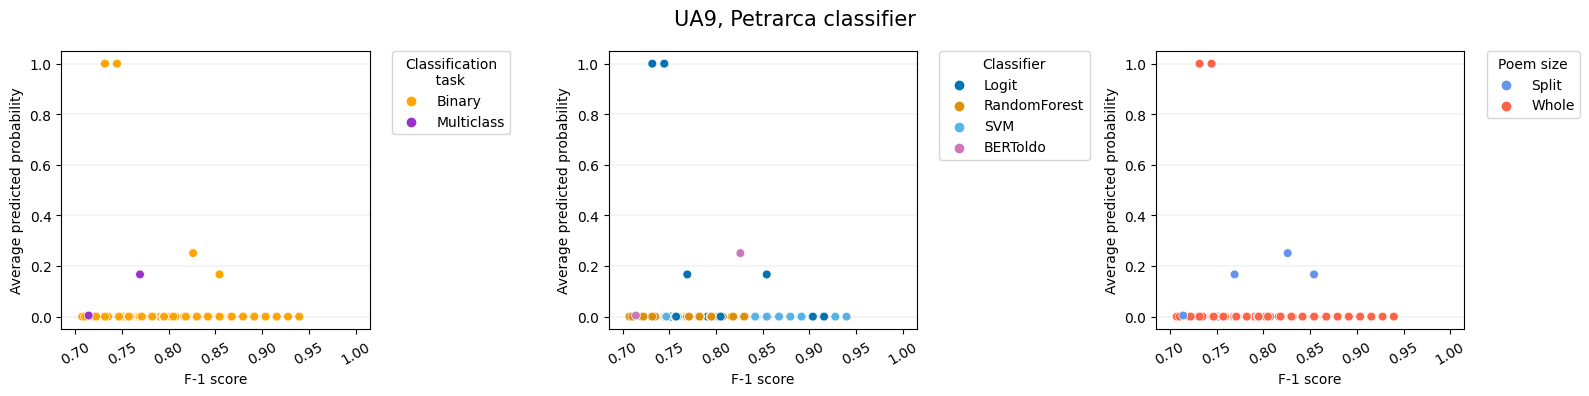

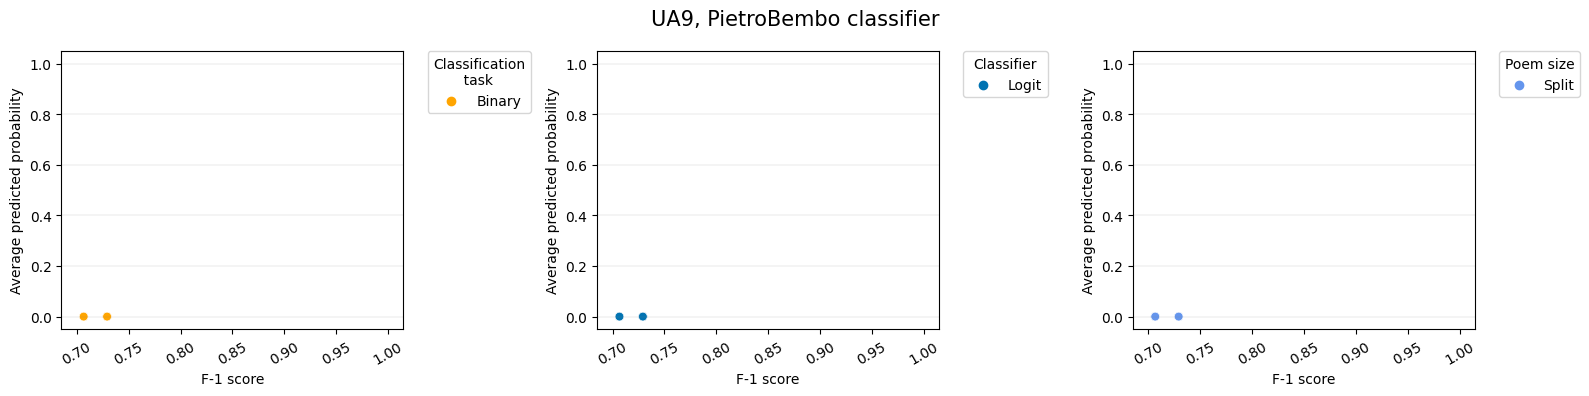

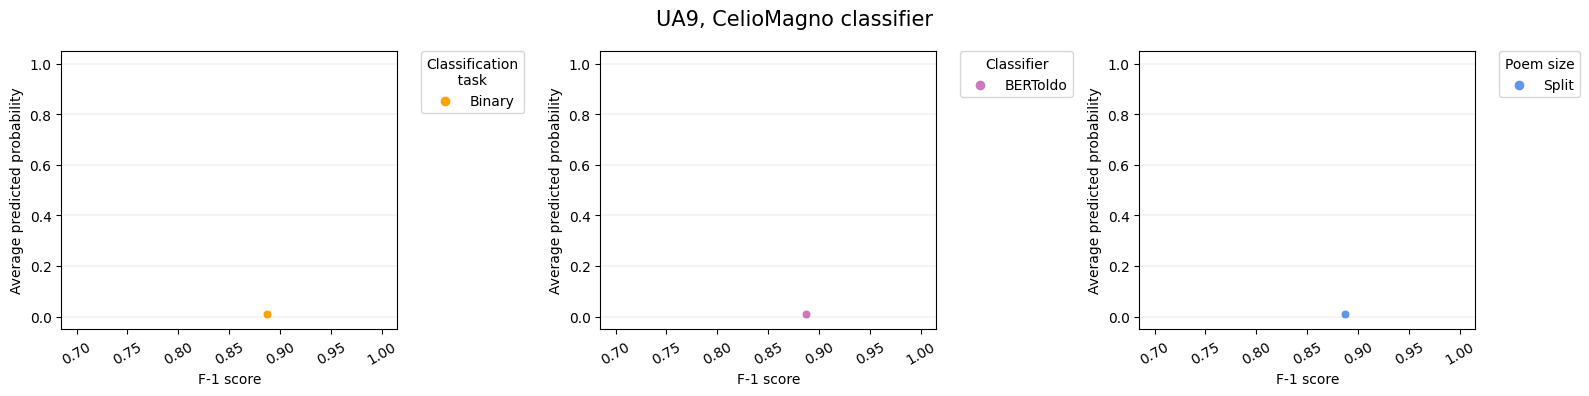

In [ ]:
make_scatterplots(all_pred, hue_map, scatter_dir)

## Box plots

In [ ]:
box_dir = os.path.join(figures_dir, 'predictions', 'boxplots')
if not os.path.exists(box_dir):
  os.makedirs(box_dir)

In [ ]:
x_map = {'f1-score': ({0.7: pltt[0], 0.8: pltt[1], 0.9: pltt[9], 1: pltt[3]}, 'F-1 score'),
           'classifier_type': ({'Binary': 'orange', 'Multiclass': 'darkorchid'}, 'Classification\n       task'),
          #  'classifier' :
          #  ({'Logit': pltt[0], 'RandomForest': pltt[1], 'SVM': pltt[9],  'kNN': pltt[3], 'BERToldo': pltt[4]}, 'Classifier'),
           'poem_type': ({'Split': 'cornflowerblue', 'Whole': 'tomato'}, 'Poem size')}

In [ ]:
def make_boxplots(_pred_df, _hue_map, _box_dir):

  for poem_label in _pred_df.label.unique():

    for author in ['Franco', 'Petrarca']:

      _figure = plt.figure(figsize = (10,4), tight_layout=0.5)
      plt.suptitle(f'{poem_label}, {author} classifier', size=15)
      plot_pos = 1

      cond = (_pred_df['label'] == poem_label) & (_pred_df['author'] == author)
      df = _pred_df.loc[cond].copy()
      df['f1-score'] = df['f1-score'].round(1)

      for _x, _tuple in _hue_map.items():

        _figure.add_subplot(1,3,plot_pos)
        ax = sns.boxplot(data=df, x=_x, y='prediction', palette=_tuple[0])
        ax.set_ylim(-0.05,1.05)

        # Calculate number of obs per group & median to position labels
        medians = df.groupby([_x])['prediction'].median().values
        nobs = df[_x].value_counts().values
        nobs = [str(x) for x in nobs.tolist()]

        # Add it to the plot
        _pos = range(len(nobs))
        for tick,label in zip(_pos,ax.get_xticklabels()):
          ax.text(_pos[tick],
            medians[tick] + 0.01,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='black',
            weight='semibold')

        ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
        ax.tick_params(axis='x', labelrotation=30)
        ax.set_ylabel(f'Predicted probability')
        ax.set_xlabel(f'{_tuple[1]}')

        plot_pos += 1

      _figure.savefig(os.path.join(_box_dir, f'{poem_label}_{author}.png'), dpi = 300, bbox_inches = "tight")

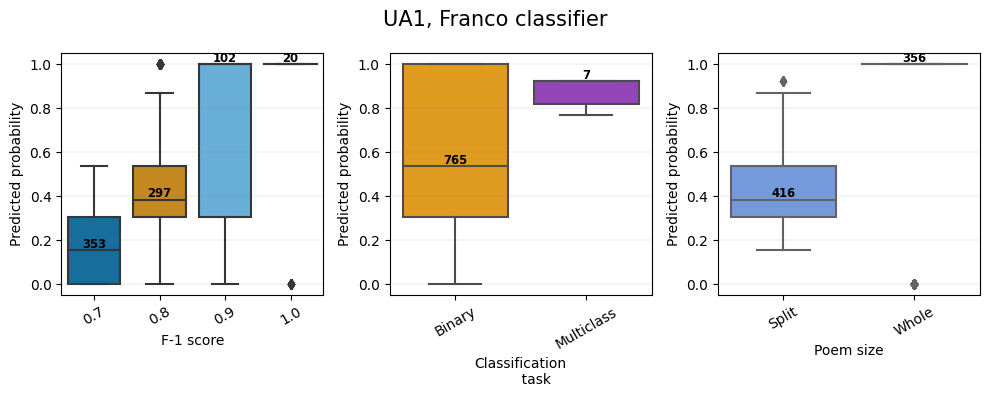

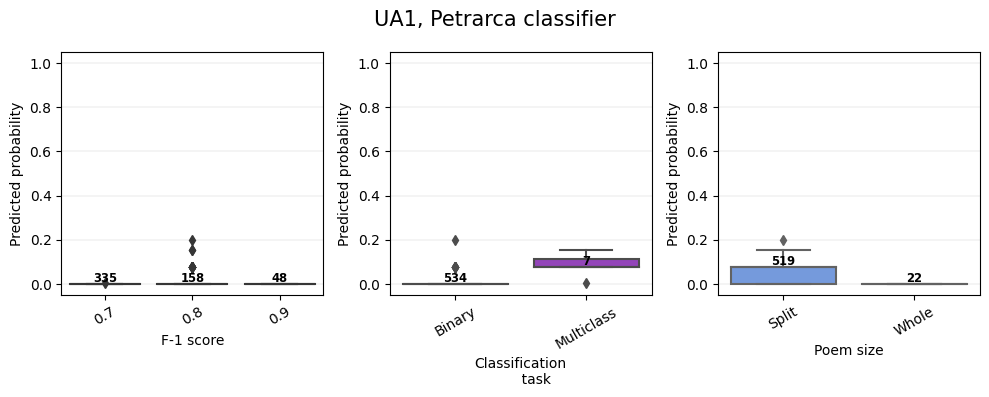

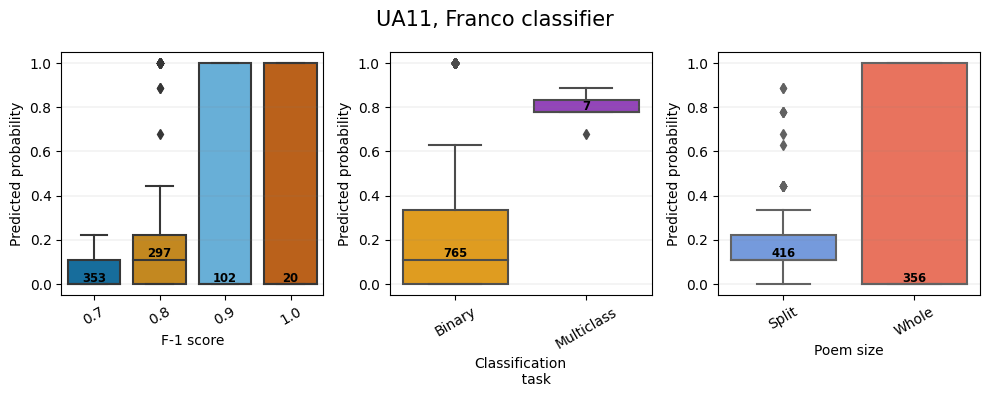

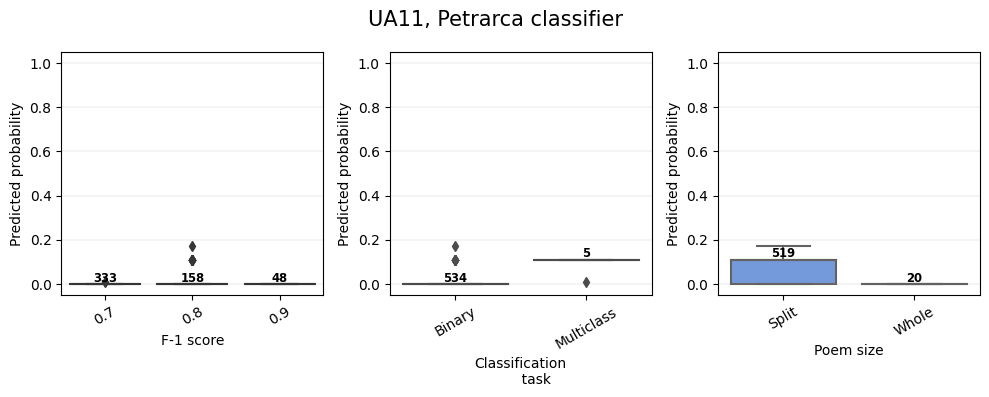

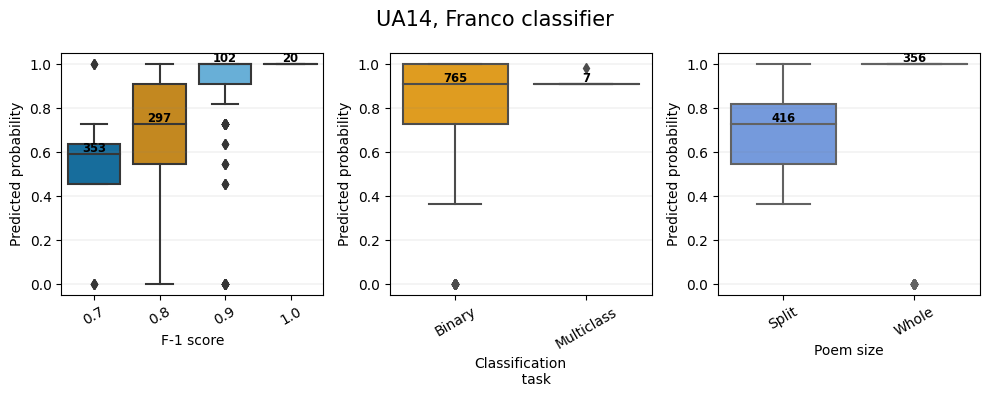

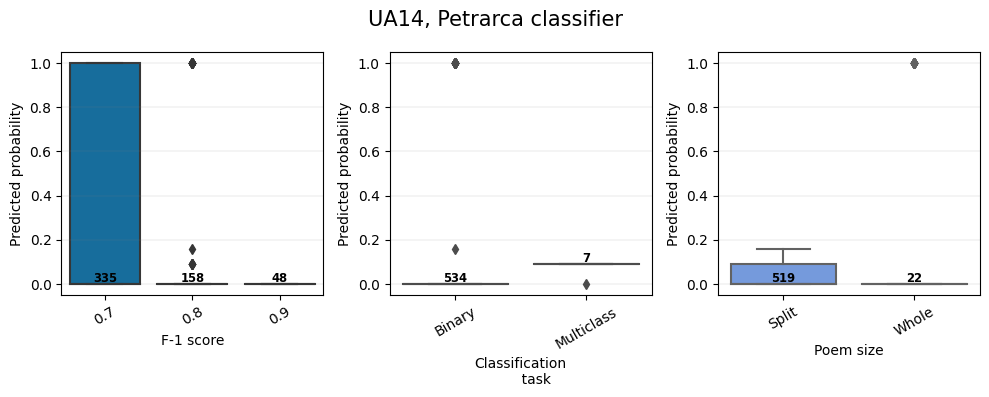

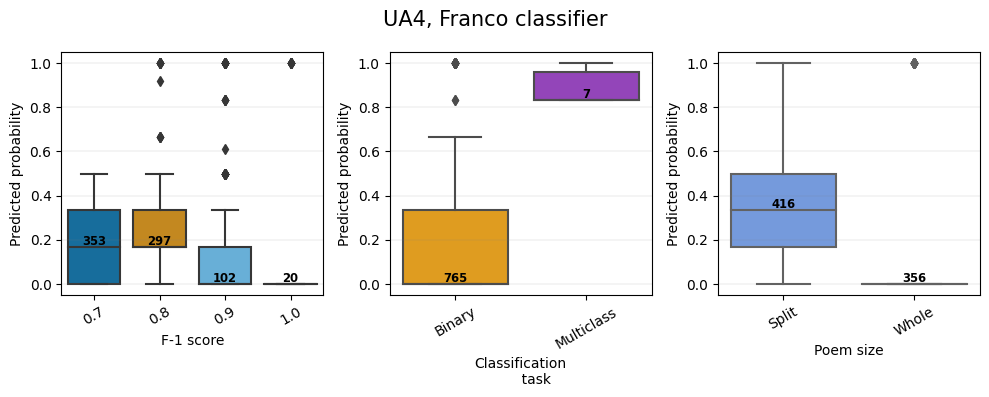

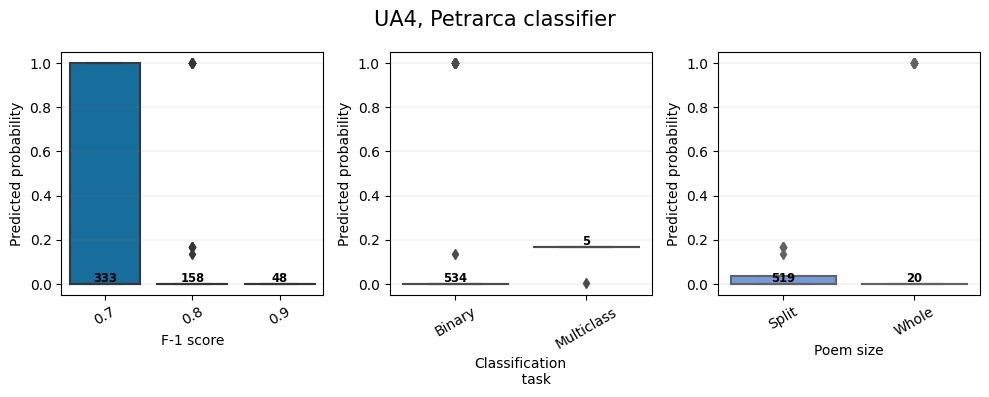

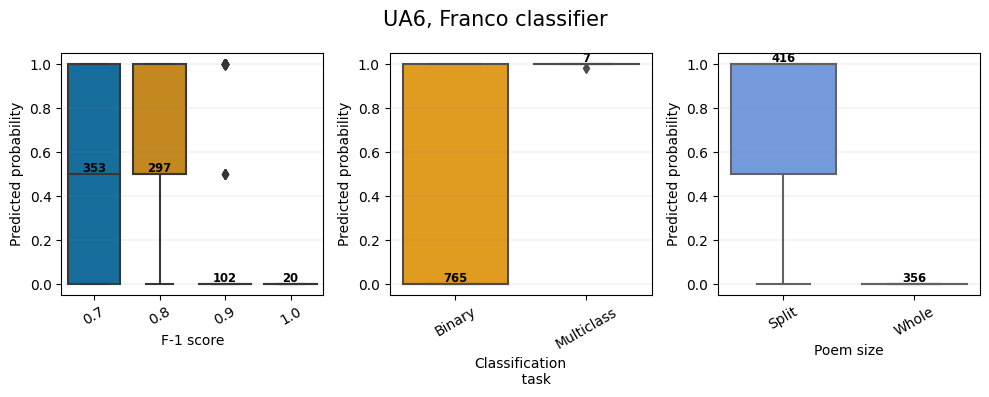

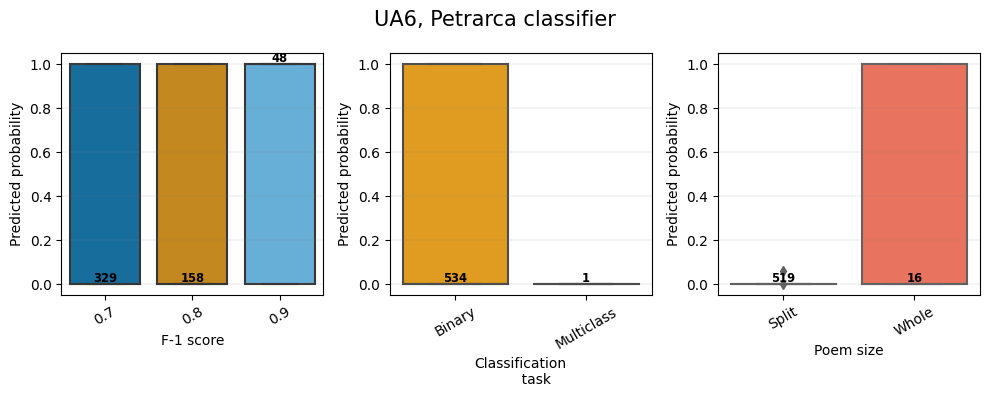

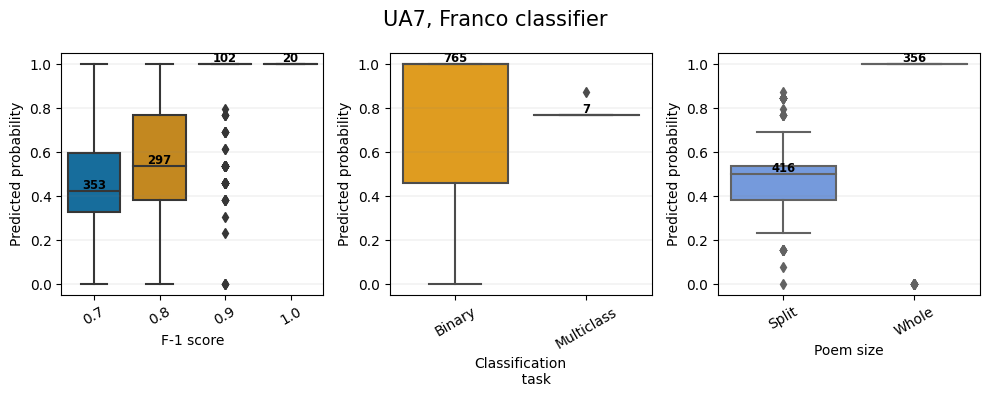

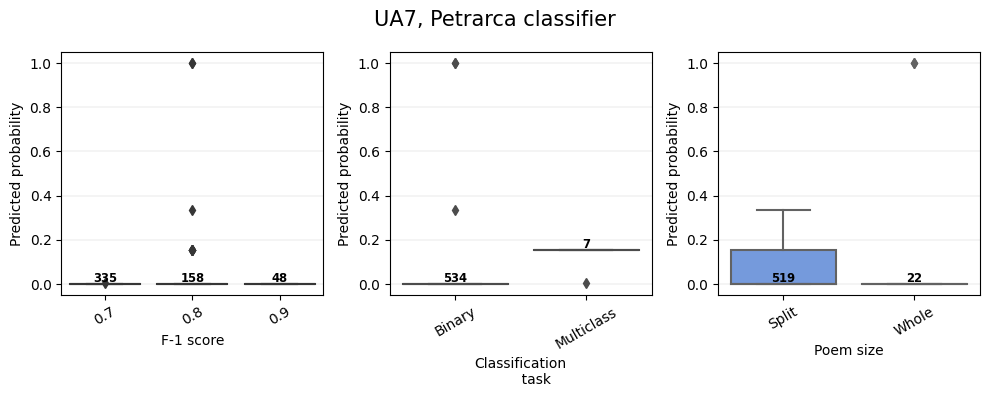

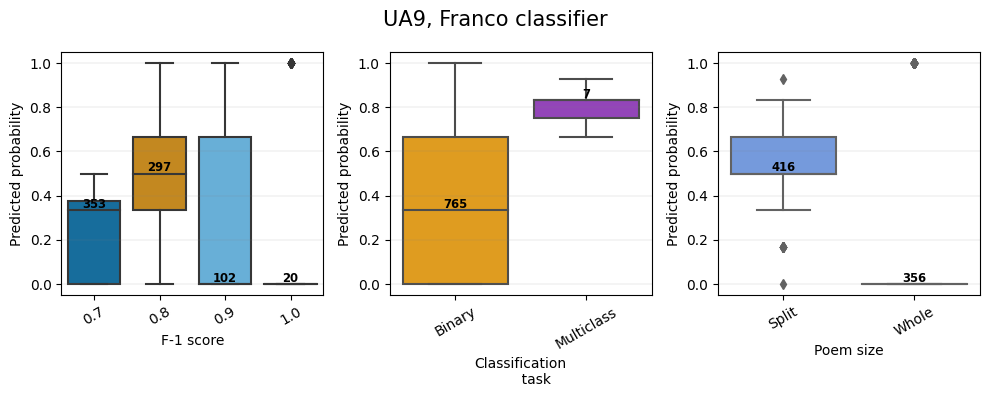

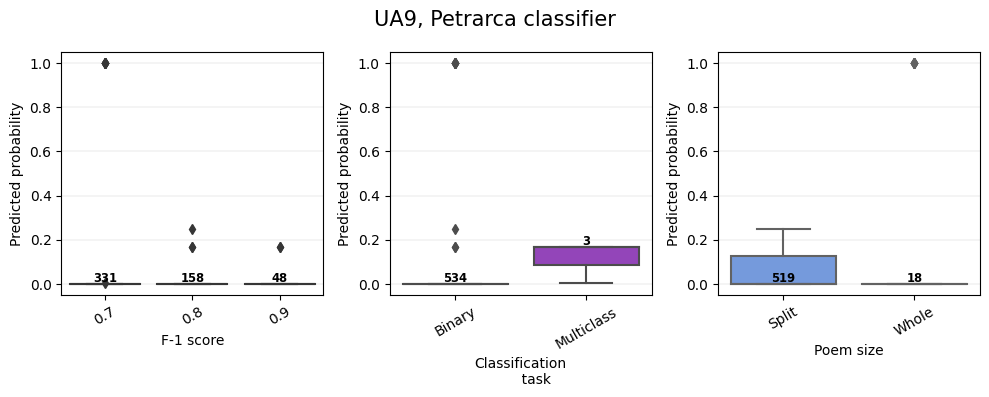

In [ ]:
make_boxplots(all_pred, x_map, box_dir)